In [27]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets.mpr_dataset import MPR_Dataset,MPR_Dataset_H5
from tqdm import tqdm_notebook as tqdm
import yaml
import re
import os
import cv2
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler
from imblearn.ensemble import BalancedRandomForestClassifier

from models import ShuffleNetv2

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xgboost as xgb
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from imblearn.datasets import make_imbalance

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

In [28]:
def convert_string_to_np_array(inp_str):
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)

    return np.array([float(x) for x in rx.findall(inp_str)])

In [109]:
np.stack(train_df['PRED'][:5])

array([[0.        , 0.02234709, 0.33575267, ..., 0.01150393, 0.0216682 ,
        0.04091497],
       [0.        , 0.03357688, 0.2650786 , ..., 0.01008779, 0.02029465,
        0.00398292],
       [0.        , 0.01345642, 0.4170723 , ..., 0.00416241, 0.00879239,
        0.03068803],
       [0.        , 0.02663072, 0.27257687, ..., 0.02410608, 0.00919888,
        0.00100142],
       [0.        , 0.02283991, 0.3043465 , ..., 0.00242686, 0.02025953,
        0.01311954]], dtype=float32)

# Data Loading

In [117]:
train_mean = np.stack(train_df['PRED']).mean()
train_std = np.stack(train_df['PRED']).std()

In [118]:
def normalize(vector, mean, std):
    return (vector - mean) / std

In [130]:
example = train_df['PRED'][0]
norm_example= normalize(train_df['PRED'][0], train_df['PRED'][0].mean(), train_df['PRED'][0].std())


In [131]:
norm_example.min()

-1.0369906

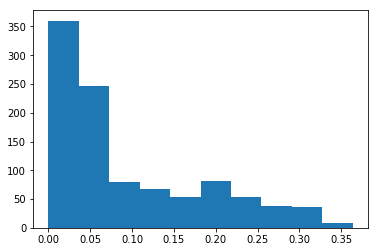

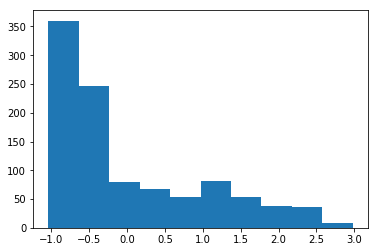

In [132]:
plt.hist(example) #calculating histogram
plt.figure()
plt.hist(norm_example) #calculating histogram

print()

In [78]:
train_df['PRED'][0].mean()

0.093955055

In [53]:
np.std(train_df['PRED'])

0.09060357

In [139]:
train_df = pd.read_pickle('ensemble/xgboost_train_features.csv')
# train_df = pd.read_csv('ensemble/xgboost_train.csv')

train_df.drop(['index'], axis=1, inplace=True)
# train_df['PRED'] = train_df['PRED'].apply(convert_string_to_np_array)
# train_df['PRED'] = train_df['PRED'].apply(np.argmax)
train_df['PRED'] = train_df['PRED'].apply(np.mean)
test_df = pd.read_pickle('ensemble/xgboost_test_features.csv')
# test_df = pd.read_csv('ensemble/xgboost_test.csv')

test_df.drop(['index'], axis=1, inplace=True)
# test_df['PRED'] = test_df['PRED'].apply(convert_string_to_np_array)
# test_df['PRED'] = test_df['PRED'].apply(np.argmax)
test_df['PRED'] = test_df['PRED'].apply(np.mean)

In [166]:
test_df[test_df['PATIENT'] == 'CTCAZHX30011957'].groupby('ARTERY_SECTION').groups

{'D-1': Int64Index([450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
             463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
             476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
             489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499],
            dtype='int64'),
 'LAD': Int64Index([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
             363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
             376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
             389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399],
            dtype='int64'),
 'LCX': Int64Index([300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
             313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
             326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
             339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349],
            dt

In [ ]:
''

# Aggregate the datatable

In [140]:
def get_data(grouped_by_patients):
    
    X = list()
    y = list()
    
    for patient in tqdm(grouped_by_patients['PATIENT'].unique()):
        cur_patient = grouped_by_patients.get_group(patient[0])
        grouped_by_section = cur_patient.groupby('ARTERY_SECTION')        

        for section in grouped_by_section['ARTERY_SECTION'].unique():
            all_images_per_section = grouped_by_section.get_group(section[0])

            train_data = np.stack(all_images_per_section['PRED'], axis=0)
            label = all_images_per_section['LABEL'].iloc[0]

            if len(train_data) ==50:
                X.append(train_data.ravel())
                y.append(label)  
    return np.stack(X), np.array(y)

In [141]:
X_train, y_train = get_data(train_df.groupby('PATIENT'))
X_test, y_test = get_data(test_df.groupby('PATIENT'))

In [142]:
X_train.shape, y_train.shape

((3242, 50), (3242,))

In [143]:
X_test.shape, y_test.shape

((486, 50), (486,))

# Train

# LIB FOR IMBALANCED LEARNING
https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/

In [144]:
# model = xgb.XGBClassifier()
# model = LinearDiscriminantAnalysis()
# model = KNeighborsClassifier()
# model = DecisionTreeClassifier()

# 85 79 81
# model = xgb.XGBClassifier(learning_rate=0.001, n_estimators=3, max_depth=2,
#                     min_child_weight=2, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
#                     nthread=4, scale_pos_weight=1, seed=32)

# 85 81 82
model = xgb.XGBClassifier(learning_rate=0.0001, n_estimators=100, max_depth=4,
                    min_child_weight=2,  subsample=0.6, colsample_bytree=1.0,
                    nthread=4, scale_pos_weight=1, seed=42)
# model = SVC()
# 69 71 70 / 82 81 81 
# model = BalancedRandomForestClassifier(max_depth=3)  # {0: 1, 1: 0.5, 2:0.4}

In [145]:
sampling_strategy = {0: 2346, 1:670*3, 2:226*10}
# sampling_strategy = {0: 226, 1:226, 2:226}

ros = RandomOverSampler(sampling_strategy=sampling_strategy)
# ros = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(X_train, y_train)

unique, counts = np.unique(y_res, return_counts=True)
dict(zip(unique, counts))

{0: 2346, 1: 2010, 2: 2260}

In [146]:
# Train
model.fit(X_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0,
              learning_rate=0.0001, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.6, verbosity=1)

In [147]:
# # LightGBM params: https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst

# param = {}
# param['application'] = 'multiclass'
# param['num_class'] = '3'
# param['learning_rate'] = 0.01
# param['feature_fraction'] = 0.4
# param['bagging_fraction'] = 0.4
# param['bagging_freq'] = 1
# param['max_depth'] = 5
# param['num_threads'] = 4
# param["verbose"] = 0
# param["metric"] = ''

# lgb_train = lgb.Dataset(X_res, label=y_res)
# lgb_val = lgb.Dataset(X_test, label=y_test)

# model = lgb.train(param, lgb_train, 1000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=10,  verbose_eval=0)

In [148]:
# # For LightGBM

# y_pred = model.predict(X_train)
# predictions = [round(np.argmax(value)) for value in y_pred]
# accuracy = accuracy_score(y_train, predictions)
# print('TRAIN: ')
# print(classification_report(predictions, y_train))

# y_pred = model.predict(X_test)
# predictions = [round(np.argmax(value)) for value in y_pred]
# print('TEST:')
# print(classification_report(predictions, y_test))

In [149]:
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print('TRAIN: ')
print(classification_report(predictions, y_train))

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
print('TEST:')
print(classification_report(predictions, y_test))

TRAIN: 
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2156
           1       0.30      0.65      0.41       311
           2       0.94      0.27      0.43       775

    accuracy                           0.69      3242
   macro avg       0.67      0.59      0.55      3242
weighted avg       0.77      0.69      0.67      3242

TEST:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       324
           1       0.07      0.22      0.11        37
           2       0.68      0.21      0.32       125

    accuracy                           0.59       486
   macro avg       0.50      0.40      0.40       486
weighted avg       0.68      0.59      0.60       486



In [ ]:
y_pred = model.predict(X_res)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_res, predictions)
print('TRAIN: ')
print(classification_report(predictions, y_res))

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
print('TEST:')
print(classification_report(predictions, y_test))

# Predict on test

In [150]:
grouped_by_patients = test_df.groupby('PATIENT')

predicts = []
indexes = []

for patient in tqdm(grouped_by_patients['PATIENT'].unique()):
    cur_patient = grouped_by_patients.get_group(patient[0])
    grouped_by_section = cur_patient.groupby('ARTERY_SECTION')        
    
    for section in grouped_by_section['ARTERY_SECTION'].unique():
        all_images_per_section = grouped_by_section.get_group(section[0])
        
        test_data = np.stack(all_images_per_section['PRED'], axis=0)
        
        # Predict
        test_data = np.expand_dims(test_data.ravel(), axis=0)
        pred = model.predict(test_data)
        predicts += list(pred)*50
        indexes += list(all_images_per_section.index)
        
test_df['PRED'] = pd.Series(data=predicts, index=indexes)

In [151]:
def calculate_metrics(col_section, col_ids, col_preds, col_labels):
    """
    Calculate final auc and f1 metrics on three levels: per patient, per section and per artery
    :return: {dict} each metric as a key and its calculated metric as a value
    """
    assert len(col_section) == len(col_ids) == len(col_preds) == len(col_labels)

    metrics = {'ACC_section': 0, 'ACC_patient': 0, 'ACC_artery': 0, 'F1_section': 0, 'F1_patient': 0, 'F1_artery': 0}
    dict_artery = {'LAD': ['D-1', 'D-2', 'LAD', 'D-3', '2D-2', 'D-1Original', 'LADOriginal', 'D-4'],
                   'LCX': ['LCX', 'OM-2', 'OM-1', 'OM-3', 'OM', 'LCX-PLB', 'LCX-PDA', 'PLV_LCX', 'PDA_LCX'],
                   'RCA': ['RCA', 'RCA-PLB', 'RCA-PDA', 'PLV_RCA']}

    df = pd.concat([col_ids, col_section, col_preds, col_labels], axis=1)
    df = df.rename(columns={col_section.name: 'section', col_ids.name: 'patient', col_preds.name:
        'preds', col_labels.name: 'labels'})
    df['artery'] = df['section'].apply(lambda x: [k for k in dict_artery.keys() if x in dict_artery[k]][0])
    
#     df['preds'] = df['preds'].apply(lambda x: np.argmax(x))   # for lightgbm
    
    # SECTION
    section_labels = df[['preds', 'labels', 'section', 'artery', 'patient']].groupby(['patient', 'section']).agg(
        lambda x: max(x))
    preds_section = df[['preds', 'labels', 'section', 'artery', 'patient']].groupby(['patient', 'section']).agg(
        lambda x: x.value_counts().index[0])
    acc = accuracy_score(preds_section['preds'], section_labels['labels'])
    f1 = f1_score(preds_section['preds'], section_labels['labels'], average='weighted')
    metrics['ACC_section'], metrics['F1_section'] = acc, f1

    # ARTERY
    sect = section_labels.reset_index()
    artery_labels = sect.groupby(['patient', 'artery']).agg(lambda x: max(x))['labels']
    preds_artery = preds_section.reset_index().groupby(['patient', 'artery']).agg(lambda x: max(x))['preds']  
    acc = accuracy_score(preds_artery, artery_labels)
    f1 = f1_score(preds_artery, artery_labels, average='weighted')
    metrics['ACC_artery'], metrics['F1_artery'] = acc, f1

    # PATIENT
    art = artery_labels.reset_index()
    patient_labels = art.groupby(['patient']).agg(lambda x: max(x))['labels']
    preds_patient = preds_artery.reset_index().groupby(['patient']).agg(lambda x: max(x))['preds'] 
    acc = accuracy_score(preds_patient, patient_labels)
    f1 = f1_score(preds_patient, patient_labels, average='weighted')
    metrics['ACC_patient'], metrics['F1_patient'] = acc, f1

    return metrics

In [152]:
calculate_metrics(test_df['ARTERY_SECTION'], test_df['PATIENT'], test_df['PRED'], test_df['LABEL'])

{'ACC_artery': 0.5528169014084507,
 'ACC_patient': 0.3333333333333333,
 'ACC_section': 0.5864197530864198,
 'F1_artery': 0.5609377418356291,
 'F1_patient': 0.38859965471454694,
 'F1_section': 0.5972979806836968}

In [ ]:
calculate_metrics(test_df['ARTERY_SECTION'], test_df['PATIENT'], test_df['PRED'], test_df['LABEL'])

In [ ]:
calculate_metrics(test_df['ARTERY_SECTION'], test_df['PATIENT'], test_df['PRED'], test_df['LABEL'])

In [ ]:
test_df.to_csv('WIMLsubmitted_predictions.csv', index=False)